# Compare topography of results to functional/anatomical brain maps

## Set-up

### Imports

In [1]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# neuromaps and nibabel
from neuromaps.datasets import fetch_annotation, fetch_atlas
from neuromaps.resampling import resample_images
from neuromaps.plotting import plot_surf_template
from neuromaps.stats import compare_images, permtest_metric
from neuromaps.nulls import alexander_bloch

import nibabel as nib
from nibabel.fileholders import FileHolder
from nilearn import plotting


In [3]:
# custom
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from info import PATIENTS, MATERIALS
from utils import get_start_time, print_time_elapsed
from map_utils import compute_distances, compute_weights, apply_feature_weights, \
                        apply_affine, compute_weighted_average, surface_coordinates_to_map


In [4]:
# autoreaload
%load_ext autoreload
%autoreload 2

### Settings

### Functions

## Main

In [5]:
# identify / create directories
dir_output = f"{PROJECT_PATH}/data/neuromaps"
for folder in ['mni_surface_distances', 'mni_surface_weights']:
    if not os.path.exists(f"{dir_output}/{folder}"): 
        os.makedirs(f"{dir_output}/{folder}")

### load data

In [6]:
# load template MNI brain
mni152_atlas = fetch_atlas('MNI152', '1mm')
mni152_template = nib.load(mni152_atlas['6Asym_brainmask'])
output_grid = np.array(np.where(np.asarray(mni152_template.get_fdata())>0)).T

In [7]:
# load channel info
fname = f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv"
df = pd.read_csv(fname, index_col=0)
df

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,9,pat02,0,A01-A02,-65.43100,61.94490,3.55955
1,10,pat02,1,A02-A03,-70.93895,57.17765,12.15540
2,11,pat02,2,A03-A04,-75.39550,51.39440,20.94335
3,12,pat02,3,A04-A05,-78.91950,43.90980,30.13485
4,13,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...
690,1385,pat22,48,MOF_03-MOF_04,36.00000,-14.00000,3.00000
691,1386,pat22,49,MOF_04-MOF_07,40.50000,-14.00000,9.50000
692,1387,pat22,50,MOF_07-MOF_08,44.50000,-14.00000,16.50000
693,1388,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000


### project iEEG results to template brain surface

In [27]:
# load regression scores, drop Nan, average over trial type
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
df = df[['patient', 'chan_idx', 'material', 'score']]
df = df.dropna()
df = df.drop(columns='material').groupby(['patient', 'chan_idx']).mean().reset_index()
df

,patient,chan_idx,score
0,pat02,0,0.750000
1,pat02,1,0.758456
2,pat02,2,0.735088
3,pat02,3,0.733626
4,pat02,4,0.743860
...,...,...,...
665,pat22,48,0.546807
666,pat22,49,0.557367
667,pat22,50,0.524097
668,pat22,51,0.511730


In [32]:
# weight feature for each subject

# display progress
t_start = get_start_time()

# create output directory
dir_output = f"{PROJECT_PATH}/data/neuromaps/weighted_scores"
if not os.path.exists(dir_output):
    os.makedirs(dir_output)

# initialize
feat_weighted, w_max = [], []

# loop over patients
for patient in df['patient'].unique():
    print(f"\tAnalyzing patient:\t{patient}")
    df_p = df.loc[df['patient']==patient]

    # load and apply weights
    weights_in = np.load(f"{PROJECT_PATH}/data/neuromaps/mni_surface_weights/{patient}.npy")
    weights = weights_in[df_p['chan_idx'].values]
    w_max.append(np.nanmax(weights,0))
    # nan_idx = np.isnan(df_p['exponent'])
    # feat_weighted.append(apply_feature_weights(df_p['exponent'][~nan_idx], 
    #                                            weights[~nan_idx]))
    nan_idx = np.isnan(df_p['score'])
    feat_weighted.append(apply_feature_weights(df_p['score'][~nan_idx], 
                                               weights[~nan_idx]))

# convert to numpy arrays
feat_weighted = np.array(feat_weighted)
w_max = np.array(w_max)

# save to file
np.save(f"{dir_output}/weighted_scores.npy", feat_weighted)
np.save(f"{dir_output}/weights_max.npy", w_max)

print_time_elapsed(t_start, "\nTotal analysis time: ")


	Analyzing patient:	pat02
	Analyzing patient:	pat04
	Analyzing patient:	pat05
	Analyzing patient:	pat08
	Analyzing patient:	pat10
	Analyzing patient:	pat11
	Analyzing patient:	pat15
	Analyzing patient:	pat16
	Analyzing patient:	pat17
	Analyzing patient:	pat19
	Analyzing patient:	pat20
	Analyzing patient:	pat21
	Analyzing patient:	pat22

Total analysis time: 0 hour, 0 min, and 24.0 s


In [33]:
# compute the weighted average across subjects
feat_weighted = np.load(f"{PROJECT_PATH}/data/neuromaps/weighted_scores/weighted_scores.npy")
w_max = np.load(f"{PROJECT_PATH}/data/neuromaps/weighted_scores/weights_max.npy")
feat_weighted_avg = compute_weighted_average(feat_weighted, w_max)
print(f"Shape feat_weighted_avg:\t{feat_weighted_avg.shape}")

Shape feat_weighted_avg:	(1827243,)


In [34]:
# convert to brain map
brain_map = dict()
brain_map = surface_coordinates_to_map(output_grid, feat_weighted_avg,
                                       mni152_template.shape)

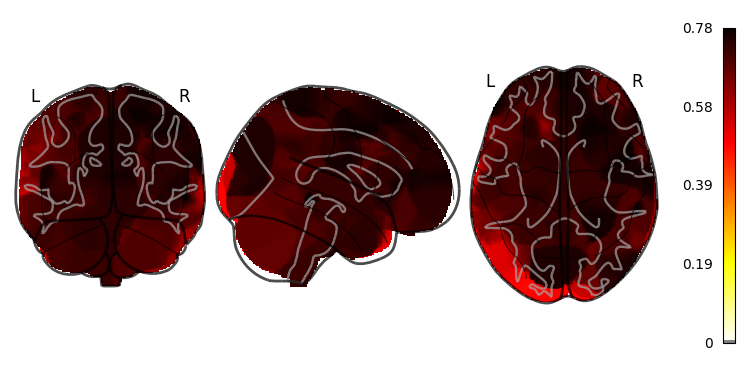

In [35]:
# save and plot

# create output directory
dir_output = f"{PROJECT_PATH}/data/neuromaps/images"
if not os.path.exists(dir_output):
    os.makedirs(dir_output)


# create image
image = nib.Nifti1Image(brain_map, mni152_template.affine)

# Save to file
fname_out = f"{dir_output}/mni.nii.gz"
nib.save(image, fname_out)

# plot
plotting.plot_glass_brain(image, colorbar=True, threshold=0.01)


### transfrom results to fsLR space and compare across maps

{('hcps1200', 'megalpha', 'fsLR', '4k'): ['C:\\Users\\micha\\neuromaps-data\\annotations\\hcps1200\\megalpha\\fsLR\\source-hcps1200_desc-megalpha_space-fsLR_den-4k_hemi-L_feature.func.gii', 'C:\\Users\\micha\\neuromaps-data\\annotations\\hcps1200\\megalpha\\fsLR\\source-hcps1200_desc-megalpha_space-fsLR_den-4k_hemi-R_feature.func.gii'], ('hcps1200', 'megbeta', 'fsLR', '4k'): ['C:\\Users\\micha\\neuromaps-data\\annotations\\hcps1200\\megbeta\\fsLR\\source-hcps1200_desc-megbeta_space-fsLR_den-4k_hemi-L_feature.func.gii', 'C:\\Users\\micha\\neuromaps-data\\annotations\\hcps1200\\megbeta\\fsLR\\source-hcps1200_desc-megbeta_space-fsLR_den-4k_hemi-R_feature.func.gii'], ('hcps1200', 'megdelta', 'fsLR', '4k'): ['C:\\Users\\micha\\neuromaps-data\\annotations\\hcps1200\\megdelta\\fsLR\\source-hcps1200_desc-megdelta_space-fsLR_den-4k_hemi-L_feature.func.gii', 'C:\\Users\\micha\\neuromaps-data\\annotations\\hcps1200\\megdelta\\fsLR\\source-hcps1200_desc-megdelta_space-fsLR_den-4k_hemi-R_feature.fu

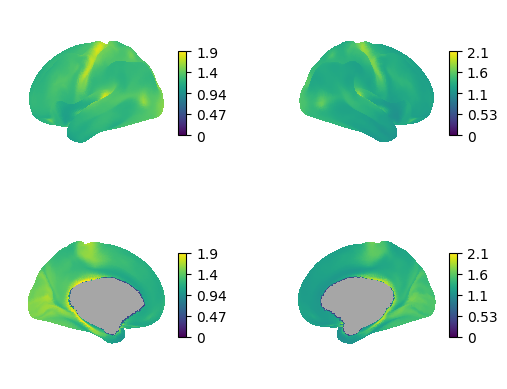

In [37]:
# load T1/T2 myelin map
# ('hcps1200', 'myelinmap', 'fsLR', '32k')

# fetch hcps1200 annotation 
hcps1200 = fetch_annotation(source='hcps1200')
print(hcps1200)

# get myelin map
keys = hcps1200.keys()
key = [k for k in keys if 'myelinmap' in k][0]
myelinmap = hcps1200[key]
print(myelinmap)

# plot myelinmap
plot_surf_template(myelinmap, 'fsLR', '32k', mask_medial=False, colorbar=True);


r = 0.022, p = 0.842


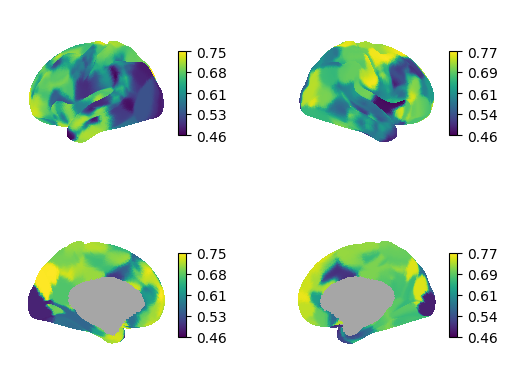

In [38]:
# resample brain map, plot, and compare to myelin map
# MNI152 will be transformed to fsLR space


# resample brain map to fsLR
fname_in = f"{PROJECT_PATH}/data/neuromaps/images/mni.nii.gz"
_, map_fslr = resample_images(src=myelinmap, trg=fname_in,
                                src_space='fsLR', trg_space='mni152',
                                method='linear', resampling='downsample_only')

# Save the fslr gifti image to a file
fslr_l, fslr_r = map_fslr
file_map_l = dict({'image': FileHolder(f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_l.gii")})
fslr_l.to_file_map(file_map_l)
file_map_r = dict({'image': FileHolder(f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_r.gii")})
fslr_r.to_file_map(file_map_r)

fname_fslr = [f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_l.gii", 
                f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_r.gii"]

# plot brain map
plot_surf_template(fname_fslr, 'fslr', '32k', colorbar=True)

# stats - compare results map to myelin map
rotated = alexander_bloch(fname_fslr, atlas='fslr', density='32k',
                                n_perm=100, seed=0) # generate null distribution
corr, pval = compare_images(myelinmap, fname_fslr, metric='pearsonr', nulls=rotated)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.022, p = 0.842


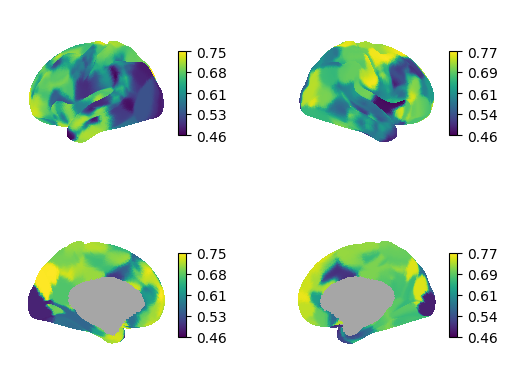

In [39]:
# resample brain map, plot, and compare to myelin map
# MNI152 will be transformed to fsLR space


# resample brain map to fsLR
fname_in = f"{PROJECT_PATH}/data/neuromaps/images/mni.nii.gz"
_, map_fslr = resample_images(src=myelinmap, trg=fname_in,
                                src_space='fsLR', trg_space='mni152',
                                method='linear', resampling='downsample_only')

# Save the fslr gifti image to a file
fslr_l, fslr_r = map_fslr
file_map_l = dict({'image': FileHolder(f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_l.gii")})
fslr_l.to_file_map(file_map_l)
file_map_r = dict({'image': FileHolder(f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_r.gii")})
fslr_r.to_file_map(file_map_r)

fname_fslr = [f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_l.gii", 
                f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_r.gii"]

# plot brain map
plot_surf_template(fname_fslr, 'fslr', '32k', colorbar=True)

# stats - compare results map to myelin map
rotated = alexander_bloch(fname_fslr, atlas='fslr', density='32k',
                                n_perm=100, seed=0) # generate null distribution
corr, pval = compare_images(myelinmap, fname_fslr, metric='pearsonr', nulls=rotated)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.175, p = 0.185


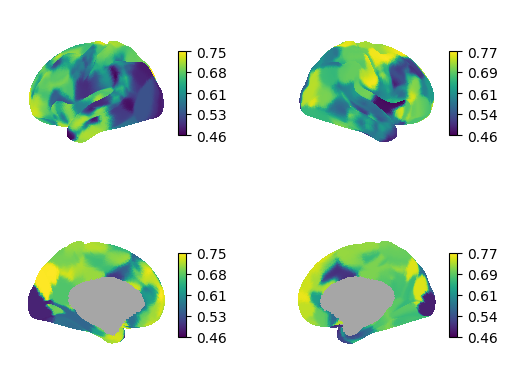

In [40]:
# resample brain map, plot, and compare to myelin map
# MNI152 will be transformed to fsLR space
# use permutation test of spearman correlation to compare maps 

# resample brain map to fsLR
fname_in = f"{PROJECT_PATH}/data/neuromaps/images/mni.nii.gz"
_, map_fslr = resample_images(src=myelinmap, trg=fname_in,
                                src_space='fsLR', trg_space='mni152',
                                method='linear', resampling='downsample_only')

# Save the fslr gifti image to a file
fslr_l, fslr_r = map_fslr
file_map_l = dict({'image': FileHolder(f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_l.gii")})
fslr_l.to_file_map(file_map_l)
file_map_r = dict({'image': FileHolder(f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_r.gii")})
fslr_r.to_file_map(file_map_r)

fname_fslr = [f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_l.gii", 
                f"{PROJECT_PATH}/data/neuromaps/images/fslr32k_r.gii"]

# plot brain map
plot_surf_template(fname_fslr, 'fslr', '32k', colorbar=True)

# stats - compare results map to myelin map
rotated = alexander_bloch(fname_fslr, atlas='fslr', density='32k',
                                n_perm=1000, seed=0) # generate null distribution
myelinmap_arr = np.concatenate([nib.load(myelinmap[0]).agg_data(), nib.load(myelinmap[1]).agg_data()])
scoremap_arr = np.concatenate([nib.load(fname_fslr[0]).agg_data(), nib.load(fname_fslr[1]).agg_data()])
corr, pval = permtest_metric(myelinmap_arr, scoremap_arr, metric='spearmanr', nulls=rotated)
print(f'r = {corr:.3f}, p = {pval:.3f}')